### sentence sentiment classification
* many to one
* variable input sequence length
* stacking
* drop out

### Import

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 추가된 import
from pprint import pprint
from tensorflow.keras.utils import to_categorical
import os
import pandas as pd
import sqlite3
import glob
import csv
pd.set_option('display.max_row', 40000)
pd.set_option('display.max_column', 10000)
from os.path import join
# tf 2.0부터 keras는 tensorflow의 공식 API
from tensorflow.keras import layers, models, optimizers

### Prepairing dataset

In [2]:
path = "src/*" #-------------------------자신의 db파일이 있는 폴더로 수정---------------------------
file_list =  glob.glob(path)
file_list_db = [file for file in file_list if file.endswith(".db")]
print ("file_list: {}".format(file_list_db))
len(file_list_db)
# EventCode03이 일어났을 당시의 초당 주행기록 가져오기
srcrec_df2 = pd.DataFrame() #연결한 db 결과 저장소
for i in range (0,len(file_list_db)):
    # event 파일 가져오기
    f = open('src/event.csv') #-------------------------자신의 event파일이 있는 폴더로 수정---------------------------
    csvReader = csv.reader(f)
    #db연결
    conn = sqlite3.connect(file_list_db[i])
    c = conn. cursor()
    # event 테이블 유무 확인 후, 있으면 제거
    c.execute('Drop Table If Exists event')
    # event 테이블 생성
    c.execute("create table event(CAR_RECDRV_KEY integer, EVENT_CODE text, EVENT_STDT text, EVENT_ENDT text)")
    # csv 파일 읽어 온 데이터 insert
    for row in csvReader:
        if row[7] == "EVENT_CODE":
            continue
        sql1 = "insert into event (CAR_RECDRV_KEY,EVENT_CODE, EVENT_STDT, EVENT_ENDT) values (?,?,?,?)"
        key= int(row[1])
        #key 추출
        if key != int(file_list_db[i][4:11]): #src에 자신의 db파일이 있어야함, 아니면 인덱스 수정할 것
            continue
        code = (row[7])
        #event 추출
        if code[-11:] != "EventCode03":
            continue
        stdt = (row[8])
        endt = (row[9])
        c.execute(sql1,(key,code,stdt,endt))
    #트랜잭션 저장
    conn.commit()
    #event03 뽐기 query 실행
    sql2 = 'SELECT SRCREC.srcValue, SRCREC.realTime, SRCREC.srcSpeed, SRCREC.srcAPS,\
    SRCREC.srcGyroValue, SRCREC.srcRPM, SRCREC.srcTPS, SRCREC.srcMAF, SRCREC.srcEngineLoad, ifnull(EVENT_CODE, "0") FROM SRCREC LEFT OUTER JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s,"-6 seconds")\
     AND strftime("%Y%m%d%H%M%S",s,"-1 seconds")'
    query =  c.execute(sql2)
    cols = [column[0] for column in query.description]
    srcrec_df = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
    #db 파일 연결 작업
    srcrec_df2 = pd.concat([srcrec_df2, srcrec_df], ignore_index=True)
    #db 연결 종료
    c.close()
    conn.close()
    #파일 연결 종료
    f.close()
srcrec_df = srcrec_df2

file_list: ['src\\2861282.db', 'src\\2861309.db', 'src\\2861323.db', 'src\\2861459.db', 'src\\2861561.db']


In [3]:
x_data = srcrec_df.apply(pd.to_numeric,errors='coerce')

x_data = x_data.iloc[:,2:9]
x_data = x_data.values
x_data= x_data.reshape(len(x_data),-1)
x_data = x_data[:,:,np.newaxis]


In [4]:
y_data = srcrec_df.values[:,9]
y_data = pd.get_dummies(y_data).values
y_data = y_data[:,0]

where_0 = np.where(y_data ==0)
where_1 = np.where(y_data ==1)

y_data[where_0] = 1
y_data[where_1] = 0
y_data = to_categorical(y_data)

### Creating model

In [5]:
num_classes = 2

model = Sequential()
model.add(layers.SimpleRNN(units=10, return_sequences=True, input_shape=[7,1]))
model.add(layers.TimeDistributed(layers.Dropout(rate = .2)))# 오버피팅 방지
model.add(layers.SimpleRNN(units=10))
model.add(layers.Dropout(rate = .2)) #오버피팅 방지
model.add(layers.Dense(units=num_classes))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 7, 10)             120       
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 10)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________


### Training model

In [7]:
#create loss function
def loss_fn(model, x, y, training):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true= y, y_pred= model(x), from_logits=True))

#create optimizer
lr=.01
epochs=30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [8]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(buffer_size = 4)
tr_dataset = tr_dataset.batch(batch_size = batch_size)

print(tr_dataset)

<BatchDataset shapes: ((None, 7, 1), (None, 2)), types: (tf.float64, tf.float32)>


In [9]:
#training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, training=True)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)
    
    if (epoch + 1) % 5 ==0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss.numpy()))

epoch :   5, tr_loss : 0.067
epoch :  10, tr_loss : 0.068
epoch :  15, tr_loss : 0.066
epoch :  20, tr_loss : 0.066
epoch :  25, tr_loss : 0.067
epoch :  30, tr_loss : 0.066


### Checking performance

In [10]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('acc : {:.2%}'.format(np.mean(yhat == y_data)))

acc : 0.00%


<ipython-input-10-88008f8eeb6a>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print('acc : {:.2%}'.format(np.mean(yhat == y_data)))


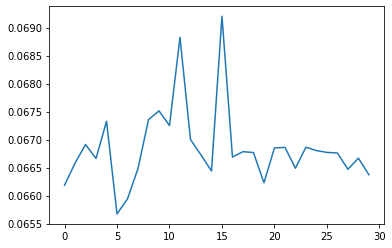

In [11]:
plt.plot(tr_loss_hist)